In [1]:
%matplotlib notebook

import PyLidar3
import numpy as np
from pynq import allocate
from pynq import Overlay
import matplotlib.pyplot as plt
import threading
import time

In [2]:
def timed(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Elapsed time for {func.__name__}: {end - start:.6f} seconds")
        return result
    return wrapper

In [3]:
def get_clusters(clusterOp_data):
    cluster_n = []  # initialize empty list for first cluster
    clusters = []  # initialize list to hold all clusters

    for value in clusterOp_data:
        if value == 720:
            if cluster_n:  # check if cluster_n already has values
                clusters.append(cluster_n)  # if so, add it to clusters
                cluster_n = []  # reset cluster_n to empty list
        else:
            cluster_n.append(value)  # add value to current cluster

    if cluster_n:  # handle the last cluster after the loop ends
        clusters.append(cluster_n)

    return clusters

In [4]:
@timed
def collect_data():
    gen = Obj.StartScanning()
    data = next(gen)
    distance = []
    for points in data:
        distance.append(data[points])
    Obj.StopScanning()
    return distance

In [5]:
@timed
def process_data(distance):
    input_buffer = allocate(shape=(360,), dtype=np.int32)
    np.copyto(input_buffer, distance)
    output_buffer = allocate(shape=(380,), dtype=np.int32)

    dma.sendchannel.transfer(input_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.transfer(output_buffer)
    dma.recvchannel.wait()

    clusterOp_data = []
    for x in output_buffer:
        if x != 0 or output_buffer.tolist().count(x) == 1:
            clusterOp_data.append(x)

    del input_buffer, output_buffer

    clusters = get_clusters(clusterOp_data)
    return clusters

In [6]:
def find_centroids(clusters, distance):
    centroids = []
    
    for cluster in clusters:
        cluster_size = len(cluster)
        clusterTheta = np.array(cluster)
        idx = np.isin(angle, clusterTheta)
        clusterDistance = np.array(distance)[np.nonzero(idx)[0]]
        
        centroid_distance = np.mean(clusterDistance)
        centroid_angle = np.mean(clusterTheta)
        
        centroids.append((centroid_angle, centroid_distance, cluster_size))
    
    return centroids

In [7]:
def update_plot(ax1, ax2, ax3, distance, clusters, centroids, master_list=[], prev_master_list=[]):
    ax1.clear()
    ax1.scatter(np.deg2rad(angle), distance, s=5)
    ax1.set_title("Raw Data")
    ax1.set_ylim(0, max(distance))

    ax2.clear()
    for cluster in clusters:
        clusterTheta = np.array(cluster)
        idx = np.isin(angle, clusterTheta)
        clusterDistance = np.array(distance)[np.nonzero(idx)[0]]
        try:
            ax2.scatter(np.deg2rad(clusterTheta), clusterDistance, s=5)
        except Exception as e:
            print('\033[31m' +str(clusterTheta) + '\033[0m')

    # Plot centroids
    centroid_angles, centroid_distances, _ = zip(*centroids)
    ax2.scatter(np.deg2rad(centroid_angles), centroid_distances, s=50, marker='x', c='red', label='Centroids')

    ax2.set_title("Clustered Data")
    ax2.set_ylim(0, max(distance))
    ax2.legend()

    ax3.clear()
    color_idx = 0
    for master_cluster in prev_master_list:
        angle1 = master_cluster['Angle']
        distance1 = master_cluster['Distance']
        size = master_cluster['Size']
        cluster_id = master_cluster['ID']
        color = f'C{cluster_id % 10}'
        ax3.scatter(np.deg2rad(angle1), distance1, s=25, marker='d', c=color)
        color_idx += 1

    color_idx = 0
    for master_cluster in master_list:
        angle1 = master_cluster['Angle']
        distance1 = master_cluster['Distance']
        size = master_cluster['Size']
        cluster_id = master_cluster['ID']
        color = f'C{cluster_id % 10}'
        ax3.scatter(np.deg2rad(angle1), distance1, s=50, marker='x', c=color)
        color_idx += 1

    ax3.set_title("Master List")
    ax3.set_ylim(0, max(distance))


In [8]:
def match_clusters(curr_centroids, master_list, threshold_distance):
    matches = []
    curr_matched = []
    master_scores = []
    for i, master_cluster in enumerate(master_list):
        min_score = float('inf')
        matched_cluster = None
        for j, curr_cluster in enumerate(curr_centroids):
            if j in curr_matched:
                continue
                
            delta_angle = abs(curr_cluster[0] - master_cluster['Angle'])
            delta_distance = abs(curr_cluster[1] - master_cluster['Distance'])
            prev_distance = master_cluster['Distance']
            delta_size = abs(curr_cluster[2] - master_cluster['Size'])
            
            if delta_distance > threshold_distance:
                continue
            
            polar_euclidean_distance = np.sqrt(delta_distance ** 2 + prev_distance ** 2 - 2 * delta_distance * prev_distance * np.cos(delta_angle))
            score = delta_size * (delta_angle * 10) * delta_distance
            
            if score < min_score:
                min_score = score
                delta_polar_distance = polar_euclidean_distance
                matched_cluster = (j, curr_cluster, score)
        
        if matched_cluster:
            matches.append((i, *matched_cluster))
            curr_matched.append(matched_cluster[0])
            master_scores.append(matched_cluster[2])
        
    # Assign new ID to current clusters not matched to any cluster in the master list
    for j, curr_cluster in enumerate(curr_centroids):
        if j not in curr_matched:
            cluster_id = len(master_list)
            master_list.append({'ID': cluster_id, 'Angle': curr_cluster[0], 'Distance': curr_cluster[1], 'Size': curr_cluster[2]})
        
    # Remove excess clusters from master_list if there are more clusters in master_list than in curr_centroids
    if len(curr_centroids) < len(master_list):
        num_clusters_to_remove = len(master_list) - len(curr_centroids)
        for i in range(num_clusters_to_remove):
            max_score_index = np.argmax(master_scores)
            master_scores.pop(max_score_index)
            master_list.pop(max_score_index)
    
    # Update the matched clusters in master_list
    new_master_list = []
    for match in matches:
        prev_index, curr_index, curr_cluster, score = match
        cluster_id = master_list[prev_index]['ID']
        new_master_list.append({'ID': cluster_id, 'Angle': curr_cluster[0], 'Distance': curr_cluster[1], 'Size': curr_cluster[2]})
    
    return new_master_list


In [9]:
angle = np.arange(0, 360)
port = "/dev/ttyUSB0"  # linux
Obj = PyLidar3.YdLidarX4(port, 12000)

if Obj.Connect():
    print(Obj.GetDeviceInfo())
else:
    print("Error connecting to device")
    exit(1)

ol = Overlay('/home/xilinx/pynq/overlays/clusterOp2/clusterOp2.bit')
ol.clusterOp2_0.register_map
CONTROL_REGISTER = 0x0
ol.clusterOp2_0.write(CONTROL_REGISTER, 0x81)  # 0x81 will set bit 0
dma = ol.axi_dma

Device status error.Try reconnecting device
Error connecting to device


<IPython.core.display.Javascript object>


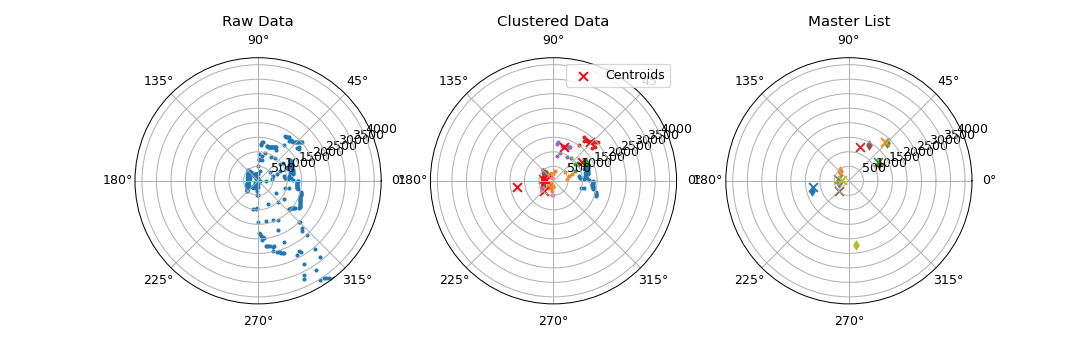

Iteration 1
Elapsed time for collect_data: 3.370291 seconds
Elapsed time for process_data: 0.110115 seconds
Elapsed time for iteration 1: 3.499191 seconds
Iteration 2
Elapsed time for collect_data: 3.369151 seconds
Elapsed time for process_data: 0.109122 seconds
9
Elapsed time for iteration 2: 4.445642 seconds
Iteration 3
Elapsed time for collect_data: 3.358073 seconds
Elapsed time for process_data: 0.112348 seconds
8
Elapsed time for iteration 3: 4.402329 seconds
Iteration 4
Elapsed time for collect_data: 3.363354 seconds
Elapsed time for process_data: 0.089549 seconds
8
Elapsed time for iteration 4: 4.417803 seconds
Iteration 5
Elapsed time for collect_data: 3.367096 seconds
Elapsed time for process_data: 0.107718 seconds
8
Elapsed time for iteration 5: 4.395714 seconds
Iteration 6
Elapsed time for collect_data: 3.370965 seconds
Elapsed time for process_data: 0.120332 seconds
8
Elapsed time for iteration 6: 4.376981 seconds
Iteration 7
Elapsed time for collect_data: 3.362614 seconds


In [10]:
iterations = 20

master_list = []
prev_centroids = []

# Initialize the plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), subplot_kw=dict(projection='polar'))
plt.ion()

for i in range(iterations):
    start_time = time.time()
    print(f"Iteration {i + 1}")

    distance = collect_data()
    clusters = process_data(distance)
    curr_centroids = find_centroids(clusters, distance)

    # Assign unique IDs to clusters in the first iteration
    if i == 0:
        for j, centroid in enumerate(curr_centroids):
            cluster_id = j
            master_list.append({'ID': cluster_id, 'Angle': centroid[0], 'Distance': centroid[1], 'Size': centroid[2]})
        
    else:
        # Match current clusters to previous clusters using master_list
        master_list = match_clusters(curr_centroids, master_list, threshold_distance=10000)
        print(len(master_list))

        update_plot(ax1, ax2, ax3, distance, clusters, curr_centroids, master_list=master_list, prev_master_list=prev_master_list)
        
    prev_centroids = curr_centroids
    prev_master_list = master_list.copy()

    end_time = time.time()
    print(f"Elapsed time for iteration {i + 1}: {end_time - start_time:.6f} seconds")

print("Done!")
Obj.Disconnect()
